#### Setup

In [11]:
from qiskit_transpiler import get_pm
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

In [12]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibm_brisbane')

#### Circuit to only pass as a gate

In [13]:
gate_circuit = QuantumCircuit(1, name='custom_rx')
gate_circuit.rx(np.pi/2,0)
custom_rx = gate_circuit.to_gate()

#### Circuit to pass for getting the calibration specific to the qubit

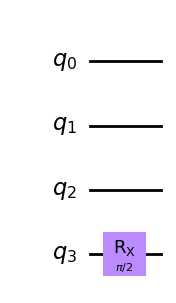

In [14]:
calibration_circuit = QuantumCircuit(4)
calibration_circuit.rx(np.pi/2,3)
calibration_circuit.draw('mpl')

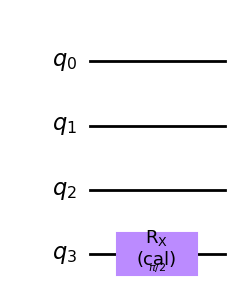

In [15]:
pm = get_pm(backend)
calibrated_circuit = pm.run(calibration_circuit)
calibrated_circuit.draw('mpl')

In [16]:
calibrated_circuit.calibrations

{'rx': {((3,),
   (1.5707963267948966,)): ScheduleBlock(Play(Drag(duration=120, sigma=30, beta=-0.5088171087648381, amp=0.07867531154093757, angle=0), DriveChannel(3)), name="rx(1.571)", transform=AlignLeft())}}

In [17]:
calibration = list(calibrated_circuit.calibrations['rx'].values())[0]

In [18]:
backend.target.add_instruction(custom_rx, {(3,): InstructionProperties(calibration=calibration)})

In [19]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [3] # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [20]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

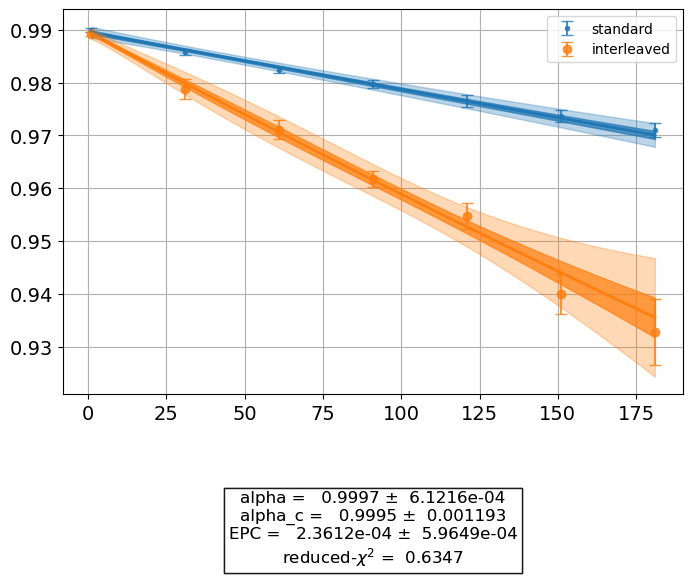

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 106
 - degree of freedom: 10
 - chi-square: 6.347224757328757
 - reduced chi-square: 0.6347224757328757
 - Akaike info crit.: -3.0745552166633434
 - Bayesian info crit.: -0.5183258982023098
 - init params:
  * a = 0.4898477994389956
  * alpha = 0.9997803862413308
  * b = 0.5
  * alpha_c = 0.9995397759044948
 - fit params:
  * a = 0.4404335715600107 ± 1.0561145023343799
  * alpha = 0.9997496659599193 ± 0.0006121571608339204
  * b = 0.5491670765434368 ± 1.05622467802181
  * alpha_c = 0.9995277578418902 ± 0.001192987062116914
 - correlations:
  * (a, b) = -0.9999999508040017
  * (alpha, b) = -0.9998252927841497
  * (b, alpha_c) = -0.9997691212284504
  * (alpha, alpha_c) = 0.999500694008492
  * (a, alpha_c) = 0.99

In [21]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

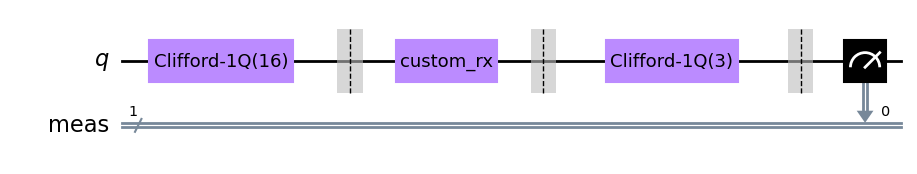

In [22]:
int_exp.circuits()[1].draw(output='mpl')

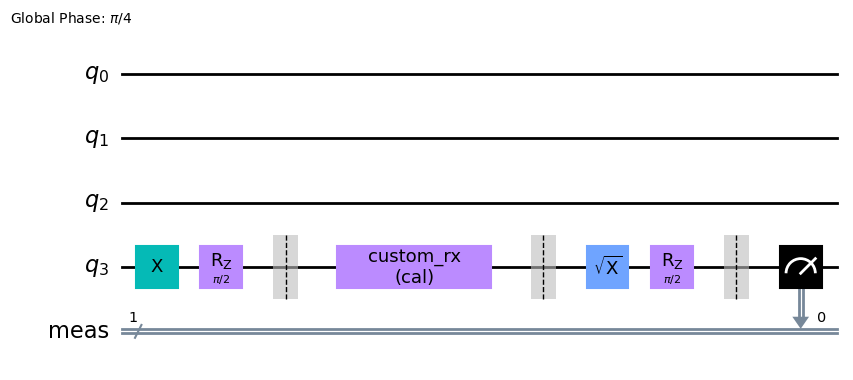

In [23]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')